In [1]:
import torch
from torch import cos, sin
import numpy as np
from math import pi, sqrt

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

from tqdm import tqdm

In [2]:
device = torch.device('cpu') # Use 'cuda' if GPU is available

In [3]:
# Generate the grid of initial conditions for the double pendulum
def generate_initial_condition(δ):
    θ1 = torch.arange(-pi+δ, pi, δ, device=device)
    θ1 = θ1[None, :].repeat(θ1.size(0), 1)
    θ2 = θ1.T
    pθ1, pθ2 = torch.zeros_like(θ1), torch.zeros_like(θ2)
    return torch.stack((θ1, θ2, pθ1, pθ2))

# Compute the derivatives of the double pendulum system
def f(V):
    θ1, θ2, pθ1, pθ2 = V
    d_θ1 = 6 * (2 * pθ1 - 3 * cos(θ1-θ2) * pθ2) / (16 - 9 * cos(θ1-θ2)**2)
    d_θ2 = 6 * (8 * pθ2 - 3 * cos(θ1-θ2) * pθ1) / (16 - 9 * cos(θ1-θ2)**2)
    d_pθ1 = - 1/2 * (d_θ1 * d_θ2 * sin(θ1-θ2) + 3 * g * sin(θ1))
    d_pθ2 = - 1/2 * (-d_θ1 * d_θ2 * sin(θ1-θ2) + g * sin(θ2))
    return torch.stack((d_θ1, d_θ2, d_pθ1, d_pθ2))

# Perform a single Runge-Kutta 4th-order step
def rk_step(V):
    V[:2] = V[:2] % (2 * pi)
    k1 = f(V)
    k2 = f(V + dt/2 * k1)
    k3 = f(V + dt/2 * k2)
    k4 = f(V + dt * k3)
    return V + dt/6 * (k1 + 2 * k2 + 2 * k3 + k4)

def plot(img):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
    im = ax.imshow(img, extent=(-pi, pi, pi, -pi), cmap='Blues')
    ax.set_xlabel('θ₁(t=0)')
    ax.set_ylabel('θ₂(t=0)')
    return im, ax

## Simulation: initial condition sensitivity

In [4]:
# Simulation parameters
T = 6 # Total simulation time
dt = 0.025 # Time step
δ = 0.005 # Step size in the initial conditions grid
g = 1.0 # Gravitational acceleration

# Main simulation loop
V = generate_initial_condition(δ)
for j in tqdm(range(int(T/dt))):
    V = rk_step(V)

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:49<00:00,  4.82it/s]


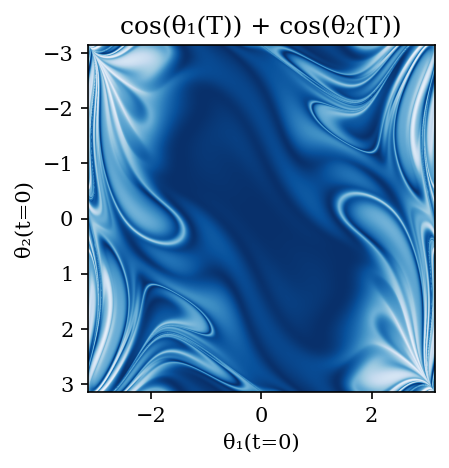

In [5]:
# Visualization of the x-position
img = cos(V[0]) + cos(V[1])
plot(img.cpu().numpy())
plt.title('cos(θ₁(T)) + cos(θ₂(T))')
plt.show()

## Simulation: Lyapunov exponent

In [6]:
# Simulation parameters
T = 30 # Total simulation time
dt = 0.025 # Time step
δ = 0.01 # Step size in the initial conditions grid
g = 1.0 # Gravitational acceleration

V = generate_initial_condition(δ)
y = torch.zeros_like(V[1])
for j in tqdm(range(int(T/dt))):
    V = rk_step(V)
    
    x = cos(V[0]) + cos(V[1])
    # Calculate the finite difference Laplacian of x
    Δx = torch.roll(x, 1, 0) + torch.roll(x, -1, 0) + torch.roll(x, 1, 1) + torch.roll(x, -1, 1) - 4 * x
    y += torch.abs(Δx) # Accumulate the absolute changes
y /= int(T/dt)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:55<00:00, 21.81it/s]


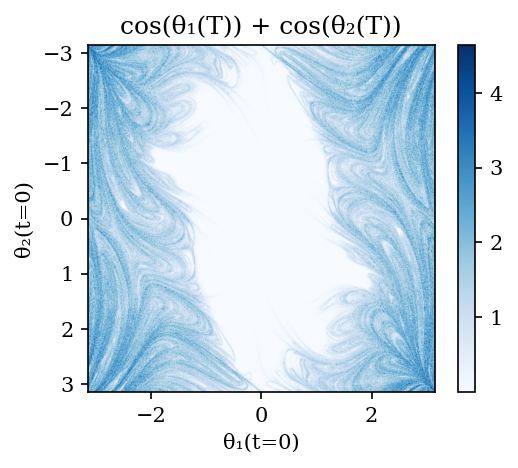

In [7]:
# Visualization of the results for the Lyapunov exponent
im, ax = plot(y.cpu().numpy())
plt.colorbar(im, ax=ax)
plt.title('cos(θ₁(T)) + cos(θ₂(T))')
plt.show()